### Scrape pollution data from offical stationary monetoring website

domain: https://luftdaten.berlin.de/lqi

1. find example request url for download: 

https://luftdaten.berlin.de/station/mc032.csv?group=pollution&period=24h&timespan=custom&start%5Bdate%5D=01.01.2016&start%5Bhour%5D=00&end%5Bdate%5D=31.12.2016&end%5Bhour%5D=00

2. iterate over dates and station id and replace keyholder in url
3. request and download id 
4. save locally


In [4]:
# scrape data on an hourly bases for 2023 from BLUME 
# takes approx. 10-15 minutes (skip): created file in dictionary)

import os
import requests
import time
import random

stations_id = ['mc010','mc018','mc027','mc032','mc042','mc077','mc085','mc115','mc117','mc124','mc143','mc144','mc145','mc171','mc174','mc190','mc221','mc282']
end_date = [31,28,31,30,31,30,31,31,30,31,30,31]
year = 2023


for id in stations_id:
    current_folder = f'data/NO2_pollution/{id}' 
    os.makedirs(current_folder) # create dict 

    for month in range(12):
        url = f'https://luftdaten.berlin.de/station/{id}.csv?group=pollution&period=1h&timespan=custom&start%5Bdate%5D=01.{month+1}.{year}&start%5Bhour%5D=00&end%5Bdate%5D={end_date[month]}.{month+1}.{year}&end%5Bhour%5D=23'
                                
        response = requests.get(url) # download csv
        response.raise_for_status() 

        file_path = os.path.join(current_folder, f'month{month+1}.csv')
        with open(file_path, 'wb') as file: 
            file.write(response.content) # save file

        time.sleep(random.randint(2,4)) # pause to avoid DoS


In [3]:
# combine to one dataframe with missing variables

import pandas as pd
df_impute = pd.DataFrame() # create empty df
stations_id = ['mc010','mc018','mc027','mc032','mc042','mc077','mc115','mc117','mc124','mc143','mc145','mc171','mc174','mc190','mc221','mc282']


for id in stations_id:
    for month in range(1,13):
        current_df = pd.read_csv(f'data/NO2_pollution/{id}/month{month}.csv', sep= ';', skiprows= [0,2,3])
        current_df.insert(1, 'id', id) # add id as column value
        df_impute = pd.concat([df_impute, current_df], ignore_index=True, sort=False, join= 'outer')
        
df_impute['date'] = df_impute['Messkomponente'].apply(lambda x:x[:10])
df_impute['time'] = df_impute['Messkomponente'].apply(lambda x:x[-5:])
df_impute['MESS_DATUM'] = df_impute['Messkomponente'].apply(lambda x:int(x[6:10]+x[3:5]+x[:2]+x[11:13]))
#df_impute = df_impute[['MESS_DATUM', 'date', 'time', 'id', 'Stickstoffdioxid']]
df_impute.drop('Messkomponente', axis = 1).to_csv('output/NO2_pollution/df_pollution_2023_berlin_na.csv', index= False)
df_impute

,Messkomponente,id,Feinstaub (PM10),"Feinstaub (PM2,5)",Stickstoffdioxid,Stickstoffmonoxid,Stickoxide,Ozon,Benzol,Toluol,Kohlenmonoxid,date,time,MESS_DATUM
0,01.01.2023 00:00,mc010,16.0,12.0,7.0,2.0,9.0,50.0,NaN,NaN,NaN,01.01.2023,00:00,2023010100
1,01.01.2023 01:00,mc010,77.0,60.0,19.0,5.0,27.0,38.0,NaN,NaN,NaN,01.01.2023,01:00,2023010101
2,01.01.2023 02:00,mc010,31.0,22.0,9.0,2.0,11.0,50.0,NaN,NaN,NaN,01.01.2023,02:00,2023010102
3,01.01.2023 03:00,mc010,19.0,11.0,5.0,2.0,7.0,54.0,NaN,NaN,NaN,01.01.2023,03:00,2023010103
4,01.01.2023 04:00,mc010,22.0,13.0,6.0,2.0,8.0,54.0,NaN,NaN,NaN,01.01.2023,04:00,2023010104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140139,31.12.2023 19:00,mc282,NaN,NaN,10.0,2.0,12.0,NaN,NaN,NaN,NaN,31.12.2023,19:00,2023123119
140140,31.12.2023 20:00,mc282,NaN,NaN,9.0,2.0,9.0,NaN,NaN,NaN,NaN,31.12.2023,20:00,2023123120
140141,31.12.2023 21:00,mc282,NaN,NaN,10.0,2.0,10.0,NaN,NaN,NaN,NaN,31.12.2023,21:00,2023123121
140142,31.12.2023 22:00,mc282,NaN,NaN,17.0,2.0,19.0,NaN,NaN,NaN,NaN,31.12.2023,22:00,2023123122


#### missing data analysis and imputation

In [5]:
# Import data 
import pandas as pd
hourly_emissions = pd.read_csv('output/NO2_pollution/df_pollution_2023_berlin_na.csv')
pivot_df = hourly_emissions.pivot(index='MESS_DATUM', columns='id', values='Stickstoffdioxid')
pivot_df['MESS_DATUM'] = pivot_df.index
pivot_df = pivot_df.reset_index(drop= True)
pivot_df

id,mc010,mc018,mc027,mc032,mc042,mc077,mc115,mc117,mc124,mc143,mc145,mc171,mc174,mc190,mc221,mc282,MESS_DATUM
0,7.0,6.0,4.0,5.0,10.0,5.0,10.0,8.0,10.0,14.0,2.0,9.0,14.0,13.0,13.0,11.0,2023010100
1,19.0,25.0,6.0,7.0,26.0,11.0,23.0,29.0,39.0,40.0,6.0,36.0,39.0,32.0,32.0,26.0,2023010101
2,9.0,9.0,3.0,5.0,10.0,8.0,13.0,17.0,17.0,26.0,3.0,15.0,18.0,16.0,15.0,11.0,2023010102
3,5.0,6.0,3.0,4.0,6.0,4.0,11.0,6.0,10.0,20.0,2.0,8.0,10.0,13.0,9.0,4.0,2023010103
4,6.0,6.0,3.0,4.0,6.0,5.0,8.0,6.0,8.0,15.0,2.0,5.0,9.0,11.0,8.0,3.0,2023010104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,22.0,23.0,5.0,8.0,18.0,11.0,27.0,26.0,19.0,26.0,20.0,18.0,29.0,40.0,28.0,10.0,2023123119
8755,19.0,20.0,6.0,8.0,19.0,11.0,25.0,22.0,24.0,34.0,17.0,20.0,24.0,46.0,27.0,9.0,2023123120
8756,25.0,24.0,6.0,9.0,26.0,13.0,28.0,23.0,27.0,41.0,14.0,22.0,24.0,45.0,31.0,10.0,2023123121
8757,27.0,21.0,5.0,10.0,22.0,17.0,28.0,18.0,22.0,34.0,17.0,23.0,34.0,47.0,28.0,17.0,2023123122


In [6]:
print(f'Total number of missing instances: {pivot_df.isna().sum().sum()}')
print(f'Missing instances per site {pivot_df.isna().sum()}')

Total number of missing instances: 722
Missing instances per site id
mc010         22
mc018         90
mc027         58
mc032         39
mc042         27
mc077         23
mc115         59
mc117         20
mc124         81
mc143         22
mc145         74
mc171         94
mc174         18
mc190         17
mc221         53
mc282         25
MESS_DATUM     0
dtype: int64


In [7]:
# find number of features missing at same timestep

def count_simultaneous_feature_absences(df, verbose = 1):
    '''
    count missing values per concrete timestep
    ----
    Input: df with timesteps as rows and features columns
    Return: dict with length of na sequence as key, and occurrence as value
    '''
    na_series_list = []
    na_series_dict = {}

    for n in range(len(df)):
        if df.iloc[n].isna().sum() > 0:
            na_series_list.append(df.iloc[n].isna().sum())
            
    try:
        for n in range(1, max(na_series_list) +1 ):
            na_series_dict[n] = na_series_list.count(n)
    except:
        print('no missing values')
        return

    # print count of na values
    if verbose == 1:
        print(f'total number of missing values: {df.isna().sum().sum()}')
        for key in na_series_dict.keys():
            if na_series_dict.get(key) > 0:
                print(f'{na_series_dict.get(key)} timesteps with {key} NA(s)')
    
    return 

count_simultaneous_feature_absences(df = pivot_df)

total number of missing values: 722
655 timesteps with 1 NA(s)
21 timesteps with 2 NA(s)
3 timesteps with 3 NA(s)
1 timesteps with 16 NA(s)


In [8]:
# count sequence length of absent data
def count_absence_lengths(df, features, index_parameter):
    
    series_missing_dict = {}

    for feature in df[features]:

        # initialize list to store the number of directly following missing values for current feature
        current_series_list = []
        # list of index (time stamp) for missing value
        index_missing_list = list(df[df[feature].isna()][index_parameter])
        #
        if len(index_missing_list) != 0:
            count = 1
            for n in range(1, len(index_missing_list)):
                
                if index_missing_list[n-1] + 1 == index_missing_list[n]:
                    count += 1
                else:
                    current_series_list.append(count)
                    count = 1
            
            current_series_list.append(count)
            current_series_list.sort(reverse= True)
            series_missing_dict[feature] = current_series_list
        else:
            series_missing_dict[feature] = [0]
            
    return series_missing_dict


series_missing_dict = count_absence_lengths(df= pivot_df,
                                         features = list(pivot_df.columns.drop('MESS_DATUM')),
                                         index_parameter = 'MESS_DATUM'
                                         )

print('Table: Features and sequence length of consecutive (in sequence) missing data')
for key in series_missing_dict.keys():
    print(f'{key}: {series_missing_dict.get(key)[:25]}')

Table: Features and sequence length of consecutive (in sequence) missing data
mc010: [3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]
mc018: [24, 24, 16, 12, 7, 1, 1, 1, 1, 1, 1, 1]
mc027: [14, 13, 9, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc032: [15, 12, 2, 2, 2, 1, 1, 1, 1, 1, 1]
mc042: [5, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc077: [5, 4, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1]
mc115: [24, 12, 8, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc117: [2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
mc124: [11, 10, 9, 8, 8, 4, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc143: [3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc145: [24, 22, 5, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc171: [24, 24, 9, 8, 8, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc174: [3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc190: [2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc221: [15, 13, 5, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
mc282: [3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


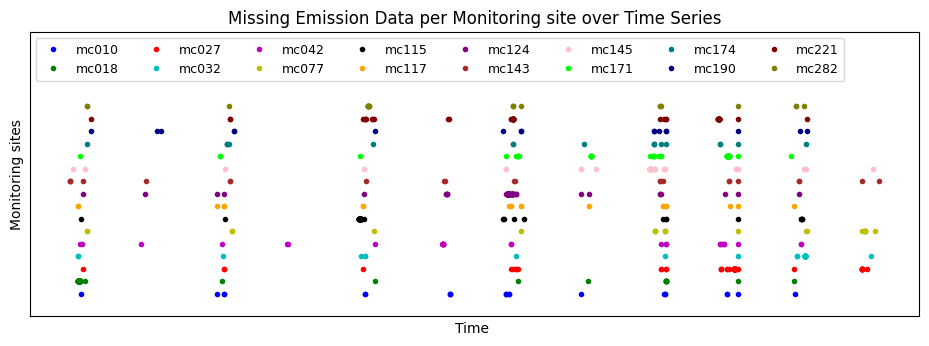

In [9]:
# plot missing data over time
import matplotlib.pyplot as plt

features = pivot_df.columns[:-1]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'navy', 'maroon', 'olive']

plt.figure(figsize=(10, 3.8)) 

for n in range(len(features)):
    current_missing = pivot_df[pivot_df[features[n]].isna()]['MESS_DATUM']
    missing_series = pd.Series([1] * len(current_missing), index=current_missing)
    plt.plot(missing_series.index, missing_series.values + (n*0.11), '.', label=features[n], color = colors[n])

plt.xlabel('Time ')
plt.title('Missing Emission Data per Monitoring site over Time Series')
plt.legend(loc= 'upper left', fontsize = 9, ncols = 8 )
plt.tight_layout()
plt.ylim([0.8,3.3])
plt.ylabel('Monitoring sites')
plt.yticks([])
plt.xticks([])
plt.savefig('output/NO2_pollution/Missing_Emission_over_time.png', dpi = 180)
plt.show()

## imputation of missing values based on other features at same timestep

- implement location based cross-validation to compare `Random Forest`, `KNN` and `Gradient Boosting` Regressor with MAE and R2 metrics

- implement imputation with spatial consideration: `kriging` & `inverse distance weighting (IDW)`

In [10]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

def model_selection(X_train, X_test, y_train, y_test, feature_name):
    '''
    Run selected model(s) and return performance
    ----
    Return: df with performance 
    '''

    models = {'RandomForestRegressor': RandomForestRegressor(), 
          'KNeighborsRegressor': KNeighborsRegressor(),
          'GradientBoostingRegressor': GradientBoostingRegressor()}
    
    # create dict with classification scores and run time
    classification_scores = {}

    for model_name, model in models.items():
        
        model = model # select model
        model.fit(X_train, y_train) # train 
        y_pred = model.predict(X_test) 
        current_mae = mean_absolute_error(y_test, y_pred) # evaluate
        current_r2 = r2_score(y_test, y_pred) # evaluate
              
        # store performance
        classification_scores[model_name] = [feature_name, model_name,
                                             round(current_mae,3),
                                             round(current_r2,3)]
        
        
    dataframe = pd.DataFrame(classification_scores, index=['feature_name', 'type', 'MAE score','R2 score'])
    print(dataframe.transpose())
    return dataframe.transpose()


# drop missing data
pivot_df_no_na = pivot_df.dropna().drop('MESS_DATUM', axis= 1)

# initalize df to store different performance
evaluation_df = pd.DataFrame(columns=['feature_name', 'type', 'MAE score','R2 score'])

# iterate over sites
for site in list(pivot_df_no_na.columns):
    
    X = pivot_df_no_na.drop(site, axis= 1)
    y = pivot_df_no_na[site]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    df_impute = model_selection(X_train = X_train, y_train  = y_train, X_test = X_test, y_test = y_test, feature_name = site )
    evaluation_df = pd.concat([evaluation_df, df_impute])
    print(f'finished: {site}')
    
evaluation_df

                          feature_name                       type MAE score  \
RandomForestRegressor            mc010      RandomForestRegressor     3.336   
KNeighborsRegressor              mc010        KNeighborsRegressor     3.392   
GradientBoostingRegressor        mc010  GradientBoostingRegressor     3.558   

                          R2 score  
RandomForestRegressor        0.836  
KNeighborsRegressor          0.825  
GradientBoostingRegressor     0.82  
finished: mc010
                          feature_name                       type MAE score  \
RandomForestRegressor            mc018      RandomForestRegressor     2.157   
KNeighborsRegressor              mc018        KNeighborsRegressor     2.235   
GradientBoostingRegressor        mc018  GradientBoostingRegressor     2.298   

                          R2 score  
RandomForestRegressor        0.923  
KNeighborsRegressor          0.917  
GradientBoostingRegressor    0.918  
finished: mc018
                          feature_name

,feature_name,type,MAE score,R2 score
RandomForestRegressor,mc010,RandomForestRegressor,3.336,0.836
KNeighborsRegressor,mc010,KNeighborsRegressor,3.392,0.825
GradientBoostingRegressor,mc010,GradientBoostingRegressor,3.558,0.82
RandomForestRegressor,mc018,RandomForestRegressor,2.157,0.923
KNeighborsRegressor,mc018,KNeighborsRegressor,2.235,0.917
GradientBoostingRegressor,mc018,GradientBoostingRegressor,2.298,0.918
RandomForestRegressor,mc027,RandomForestRegressor,2.203,0.767
KNeighborsRegressor,mc027,KNeighborsRegressor,2.271,0.752
GradientBoostingRegressor,mc027,GradientBoostingRegressor,2.422,0.733
RandomForestRegressor,mc032,RandomForestRegressor,2.185,0.742


In [15]:
# average performance by type
evaluation_df['type'] = evaluation_df.index
evaluation_df.drop('feature_name', axis = 1).groupby(['type']).mean()


,MAE score,R2 score
type,,
GradientBoostingRegressor,3.2645,0.82425
KNeighborsRegressor,3.099875,0.827688
RandomForestRegressor,3.05175,0.839875


In [16]:
# use for imputing single missing values
from sklearn.ensemble import RandomForestRegressor

pivot_df_no_na = pivot_df.dropna().drop('MESS_DATUM', axis= 1) # remove missing value for training
df_impute = pivot_df.copy().reset_index(drop= True) # copy 

# implement random forest cross imputation
for site in list(pivot_df_no_na.columns): # iterate over all sites
    
    # train model on existing ALL existing data
    X = pivot_df_no_na.drop(site, axis= 1) # define X train 
    y = pivot_df_no_na[site] # define y train

    model = RandomForestRegressor()
    model.fit(X, y) # train 
    print(f"training for {site} finished")

    for n in range(len(df_impute)):
        if df_impute.iloc[n].isna().sum() == 1 and pd.isna(df_impute[site].iloc[n]): # select row with one na + at target site
                X_pred = df_impute[n:n+1].drop([site, 'MESS_DATUM'], axis = 1) # define other columns as predictor variables
                y_pred = model.predict(X_pred)
                df_impute.loc[n, site] = y_pred
                

training for mc010 finished
training for mc018 finished
training for mc027 finished
training for mc032 finished
training for mc042 finished
training for mc077 finished
training for mc115 finished
training for mc117 finished
training for mc124 finished
training for mc143 finished
training for mc145 finished
training for mc171 finished
training for mc174 finished
training for mc190 finished
training for mc221 finished
training for mc282 finished


In [17]:
# return count of simultaneously missing values 
count_simultaneous_feature_absences(df_impute)

# return count of absence sequence length 
count_absence_lengths(df= df_impute, features= df_impute.columns.drop('MESS_DATUM'), index_parameter= 'MESS_DATUM' )

total number of missing values: 67
21 timesteps with 2 NA(s)
3 timesteps with 3 NA(s)
1 timesteps with 16 NA(s)


{'mc010': [2, 1, 1, 1, 1],
 'mc018': [4, 3, 1],
 'mc027': [1, 1, 1],
 'mc032': [2, 1],
 'mc042': [1, 1],
 'mc077': [1, 1],
 'mc115': [2, 1, 1],
 'mc117': [2, 1],
 'mc124': [2, 2, 2, 1, 1, 1],
 'mc143': [1],
 'mc145': [1, 1, 1],
 'mc171': [1, 1, 1, 1],
 'mc174': [1, 1, 1, 1],
 'mc190': [1, 1],
 'mc221': [4, 2, 1, 1, 1, 1],
 'mc282': [2, 1]}

In [18]:
# linear interpolate the other missing values
df_impute = df_impute.interpolate(method= 'linear')

In [19]:
# Melt the DataFrame back into its original form
melted_df_imputed = df_impute.melt(id_vars=['MESS_DATUM'], var_name='id', value_name='Stickstoffdioxid')
melted_df_imputed.to_csv('output/NO2_pollution/df_pollution_2023_berlin_impute.csv', index = False)

## Plot which data is absense


In [22]:
import pickle

# store index of the originally missing data in dict
index_missing_data = {}
timestep_missing_data = {}

for site in pivot_df.columns.drop('MESS_DATUM'):
    current_index_missing = []
    current_date_missing = []
    for n in range(len(pivot_df)):
        if pd.isna(pivot_df[site].iloc[n]):  # Ensure consistent reference to pivot_df
            current_index_missing.append(n)
            current_date_missing.append(pivot_df['MESS_DATUM'].iloc[n])

    index_missing_data[site] = current_index_missing
    timestep_missing_data[site] = current_date_missing

# save index dict to use for training later 
with open('output/NO2_pollution/index_imputed_no2_values.pkl', 'wb') as pickle_file:
    pickle.dump(timestep_missing_data, pickle_file)


# store imputed data based index in index_missing_data
imputed_data = {}

for site in list(index_missing_data.keys()):
    current_imputed = []
    for index in index_missing_data.get(site):
        current_imputed.append(df_impute[site][index])
    imputed_data[site] = current_imputed

In [23]:
with open('output/NO2_pollution/index_imputed_no2_values.pkl', 'rb') as pickle_file:
    timestep_missing_data = pickle.load(pickle_file)

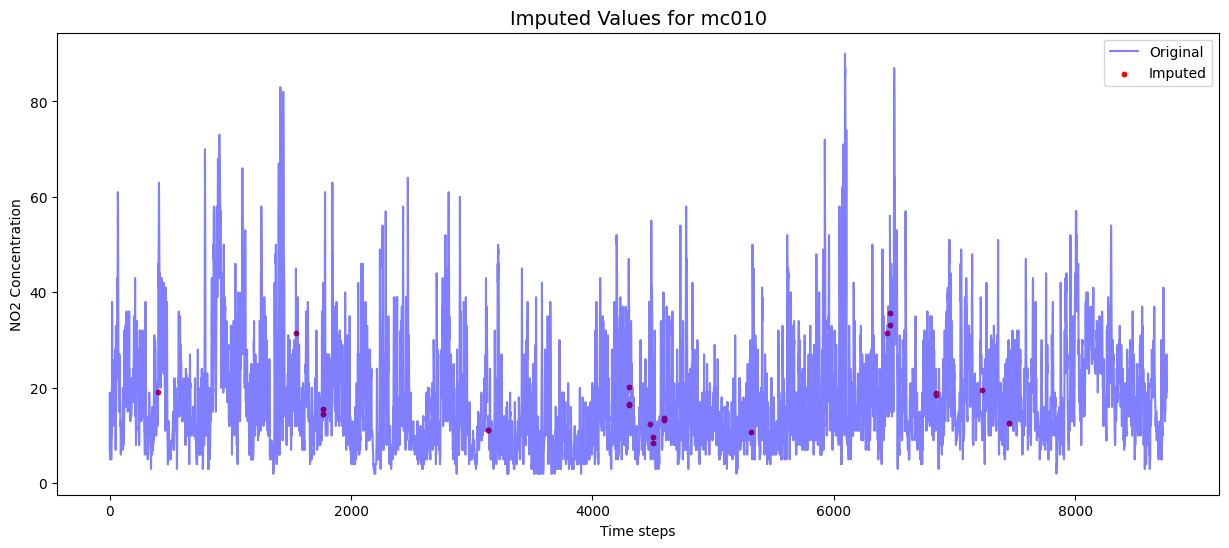

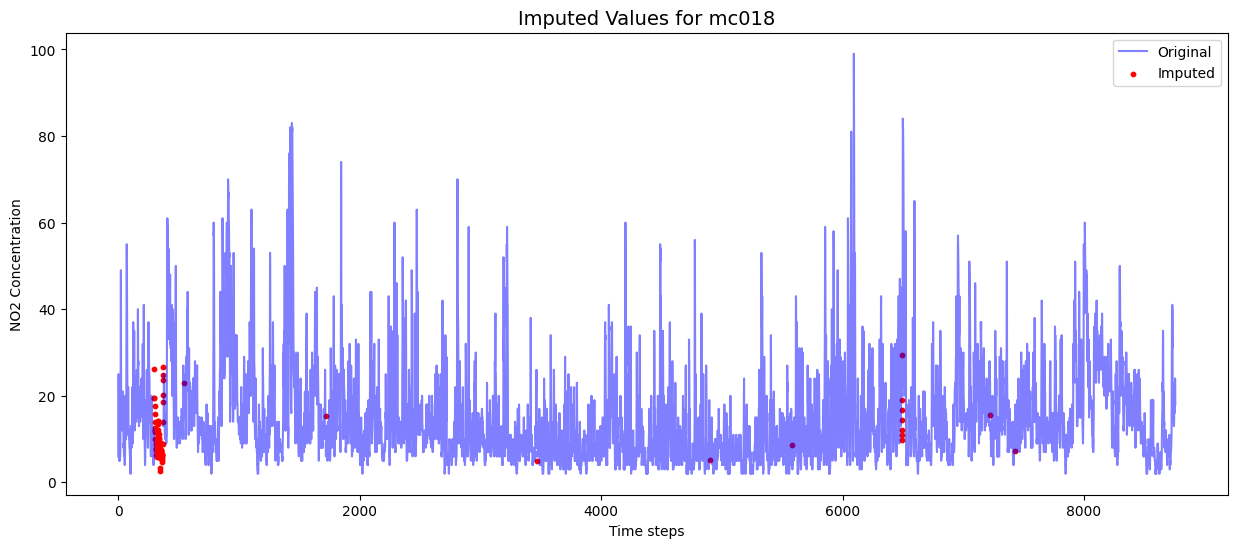

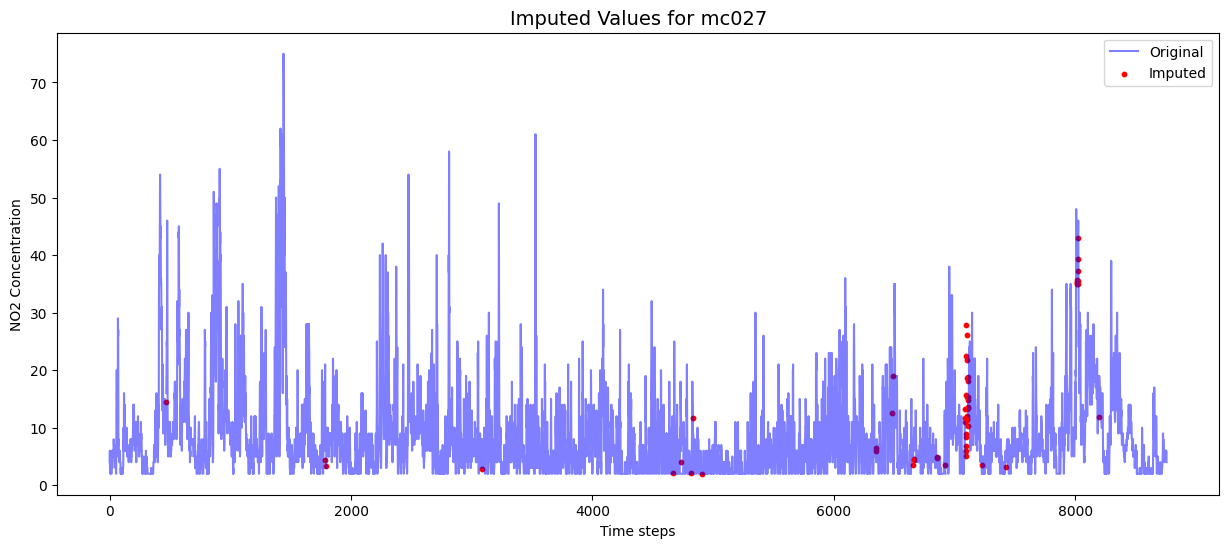

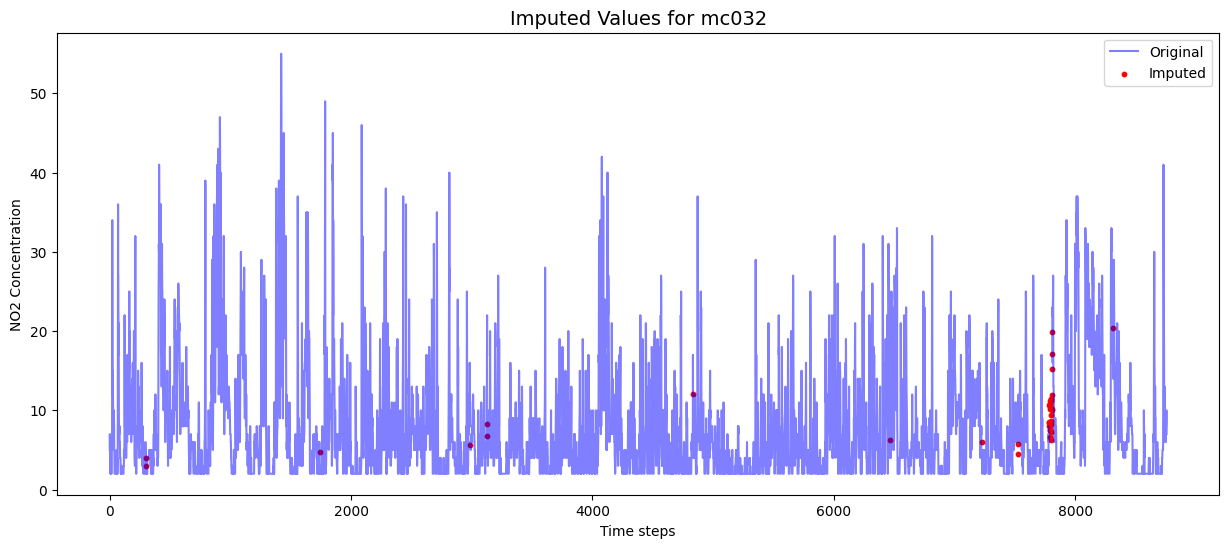

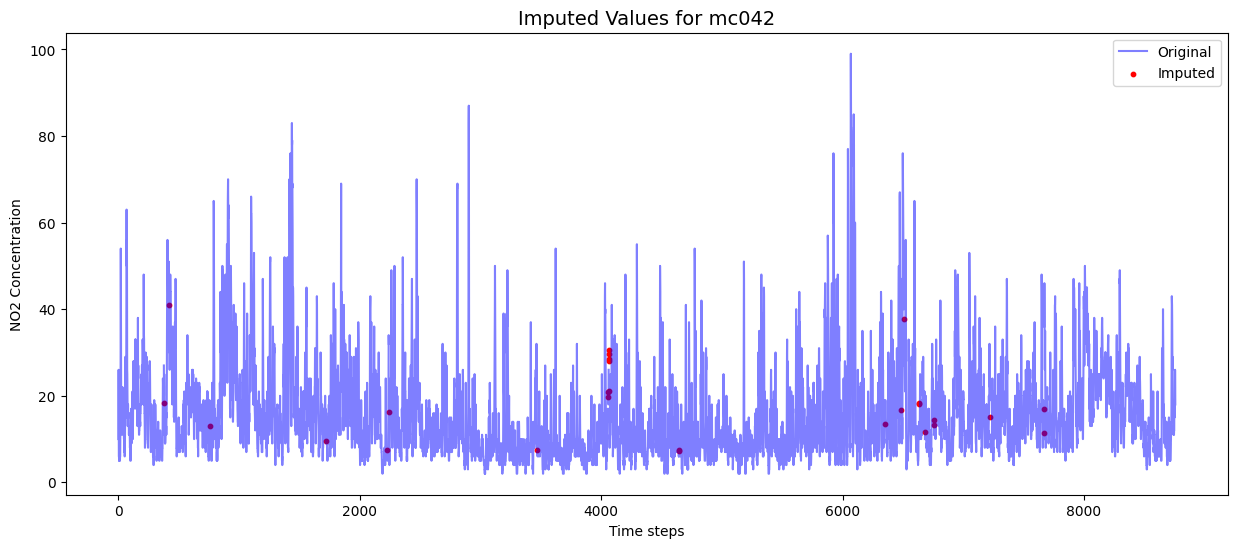

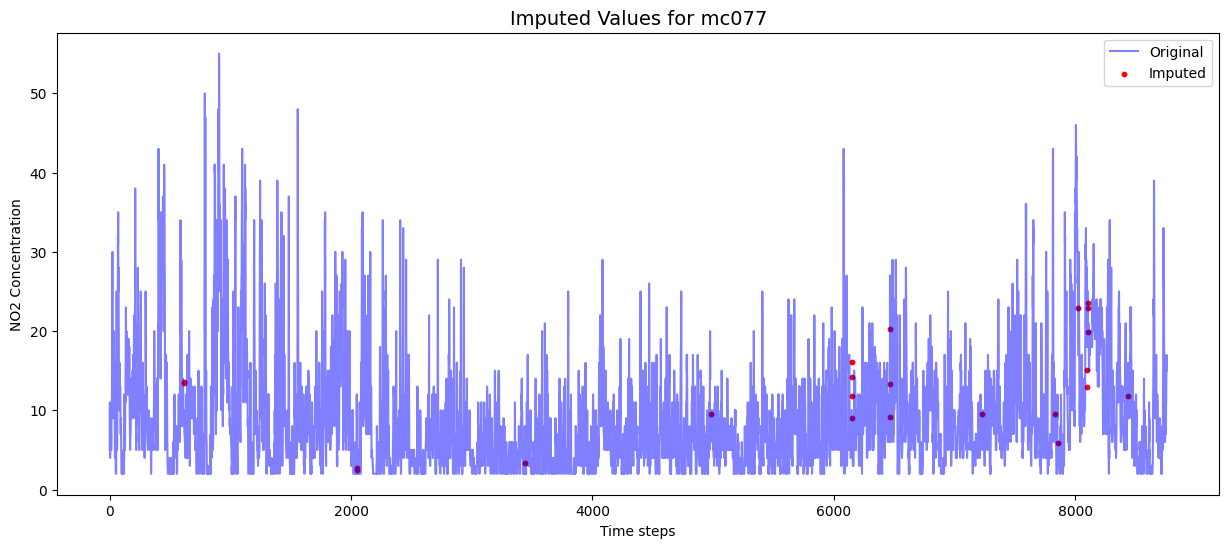

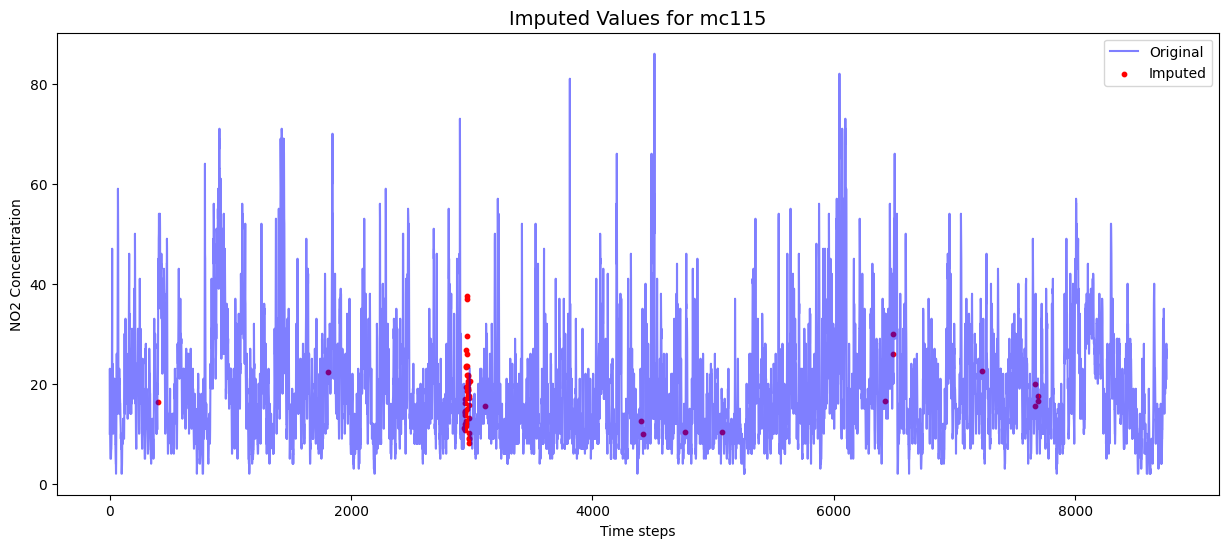

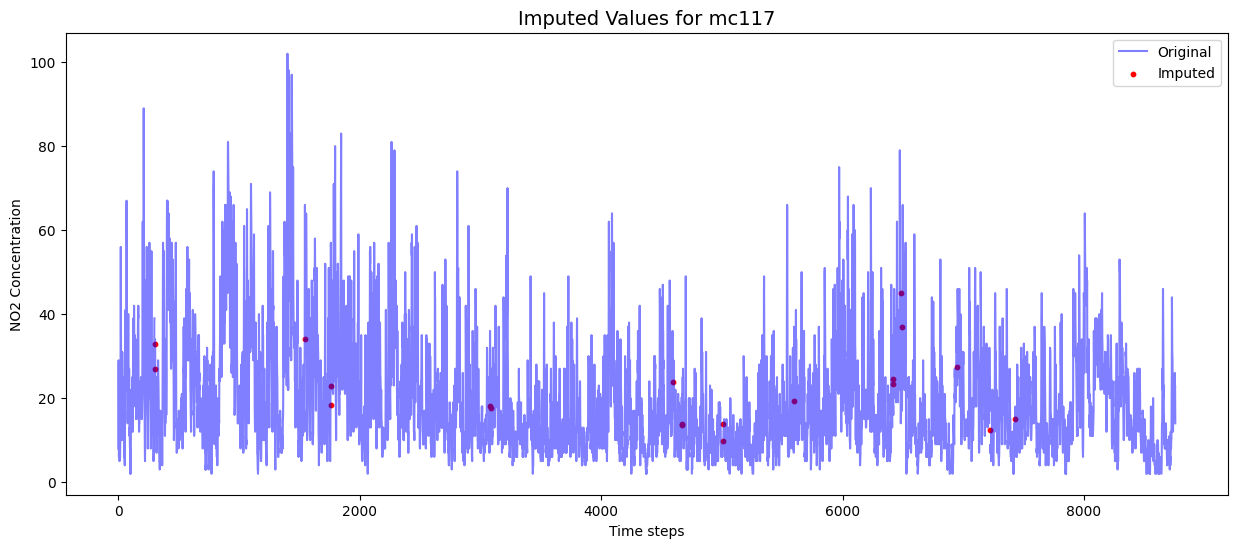

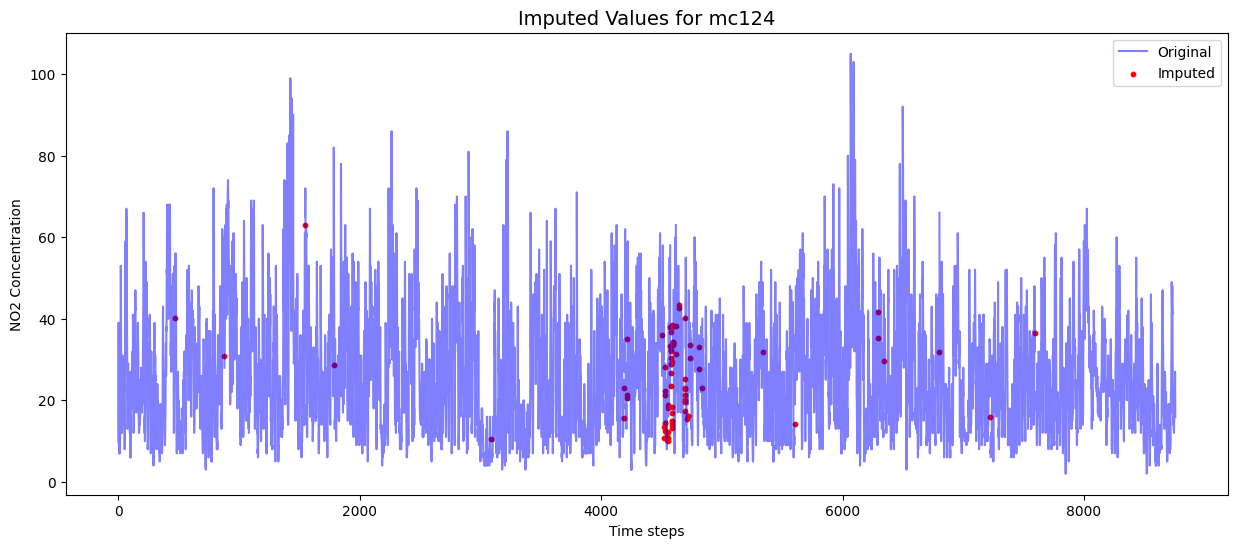

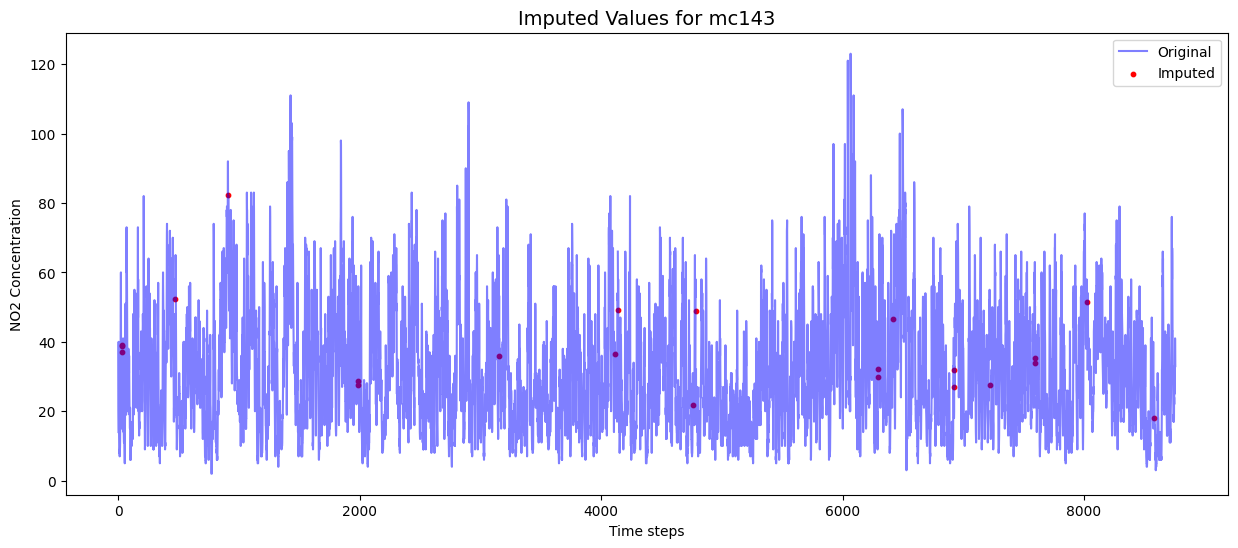

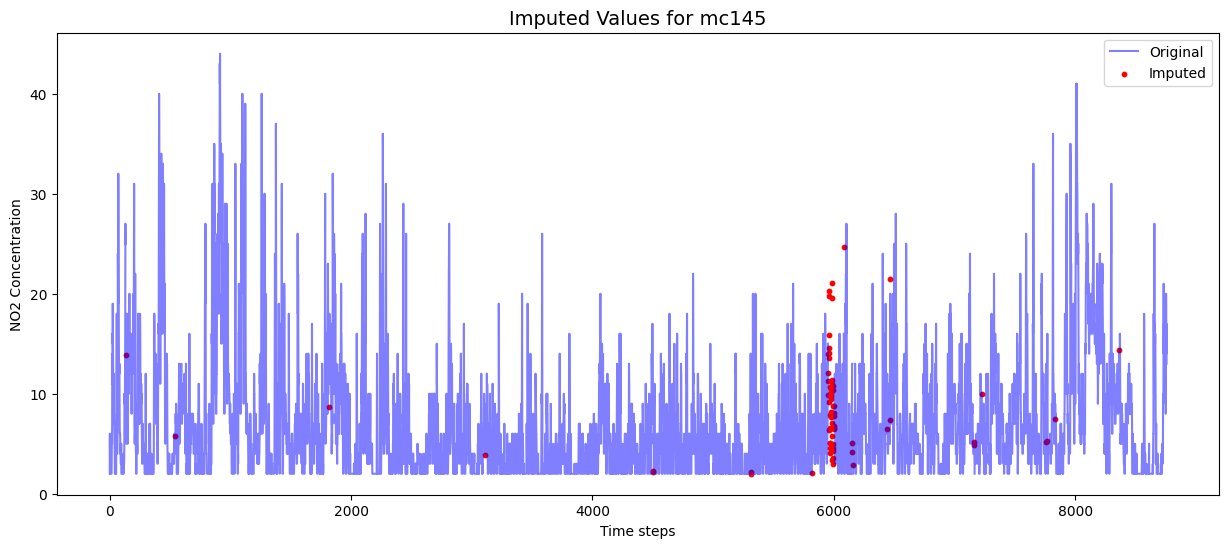

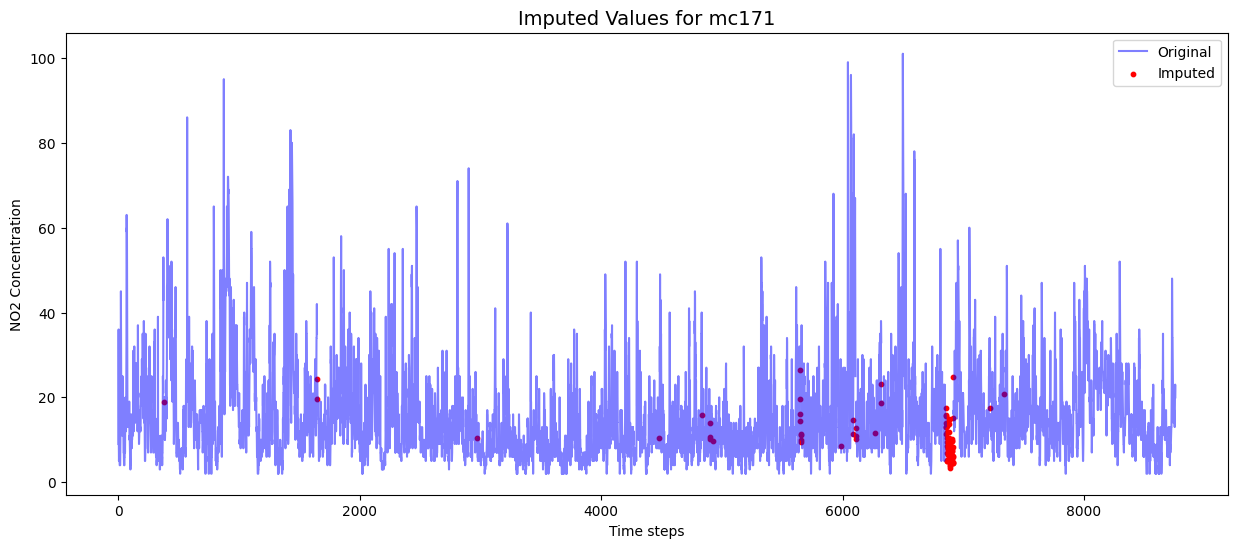

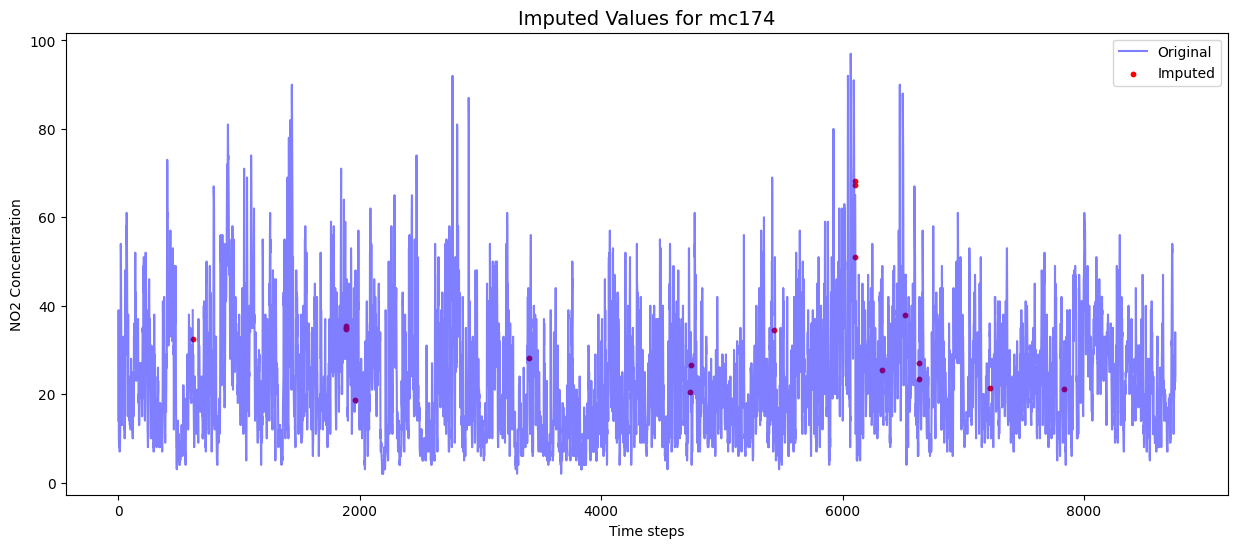

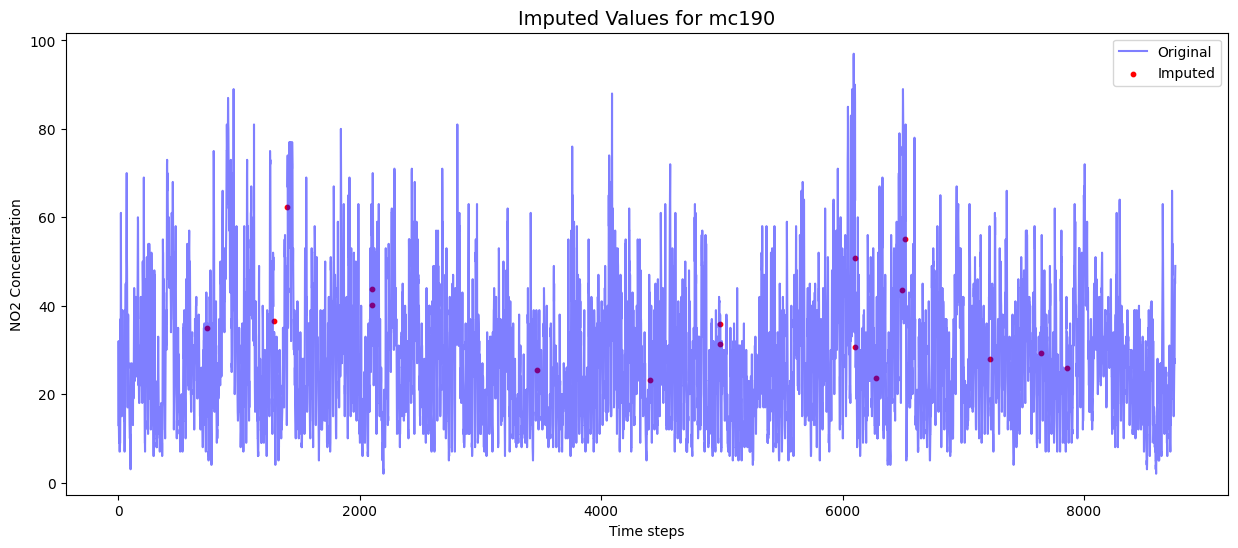

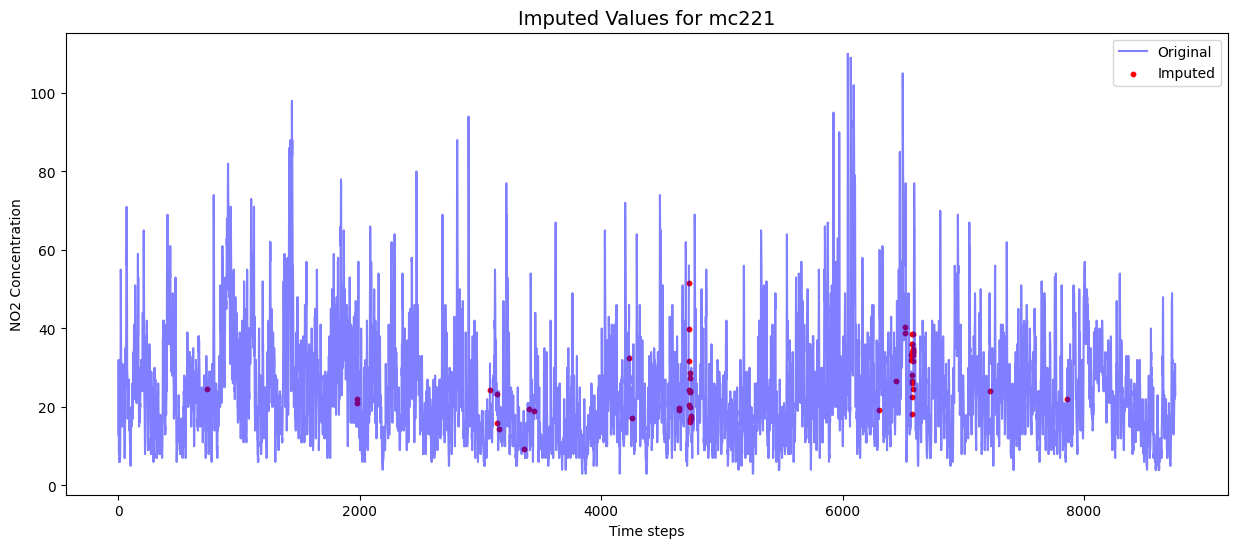

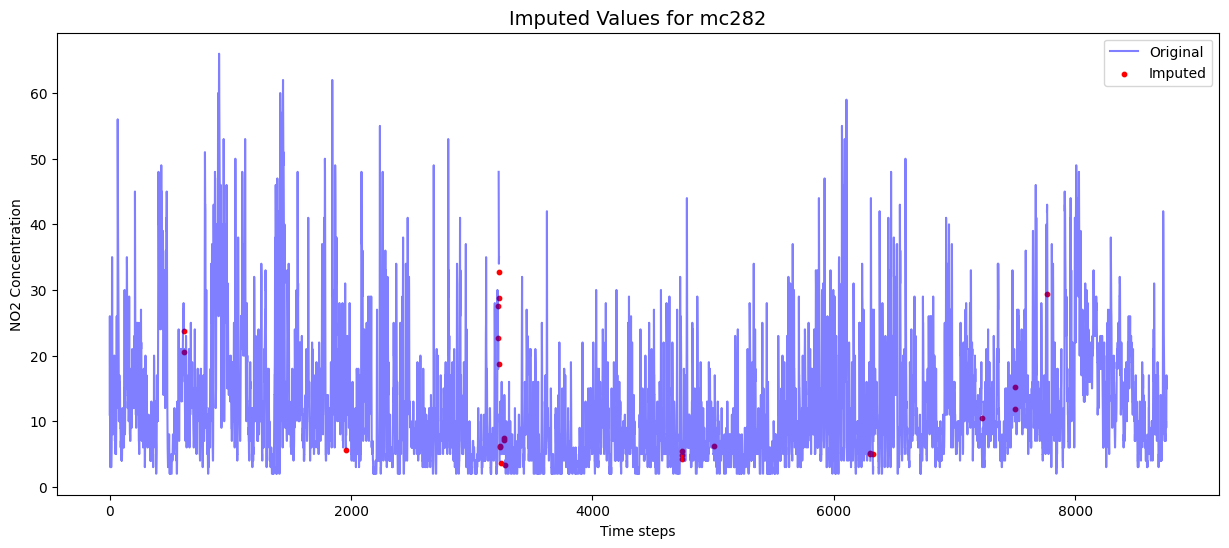

In [24]:
# plot imputed and other values over time

import matplotlib.pyplot as plt

for site in list(df_impute.columns.drop('MESS_DATUM')):
    plt.figure(figsize=(15, 6))
    # Plot original data
    plt.plot(pivot_df.index, pivot_df[site], label='Original', color='blue', alpha=0.5)
    # Highlight imputed data
    plt.scatter(pivot_df.index[index_missing_data[site]], imputed_data[site], color='red', label='Imputed', s=10)
    
    plt.title(f'Imputed Values for {site}', size = 14)
    plt.xlabel('Time steps')
    plt.ylabel('NO2 Concentration')
    plt.legend()
    plt.show()


#### comparison of distribution between imputed (absent) and existing data

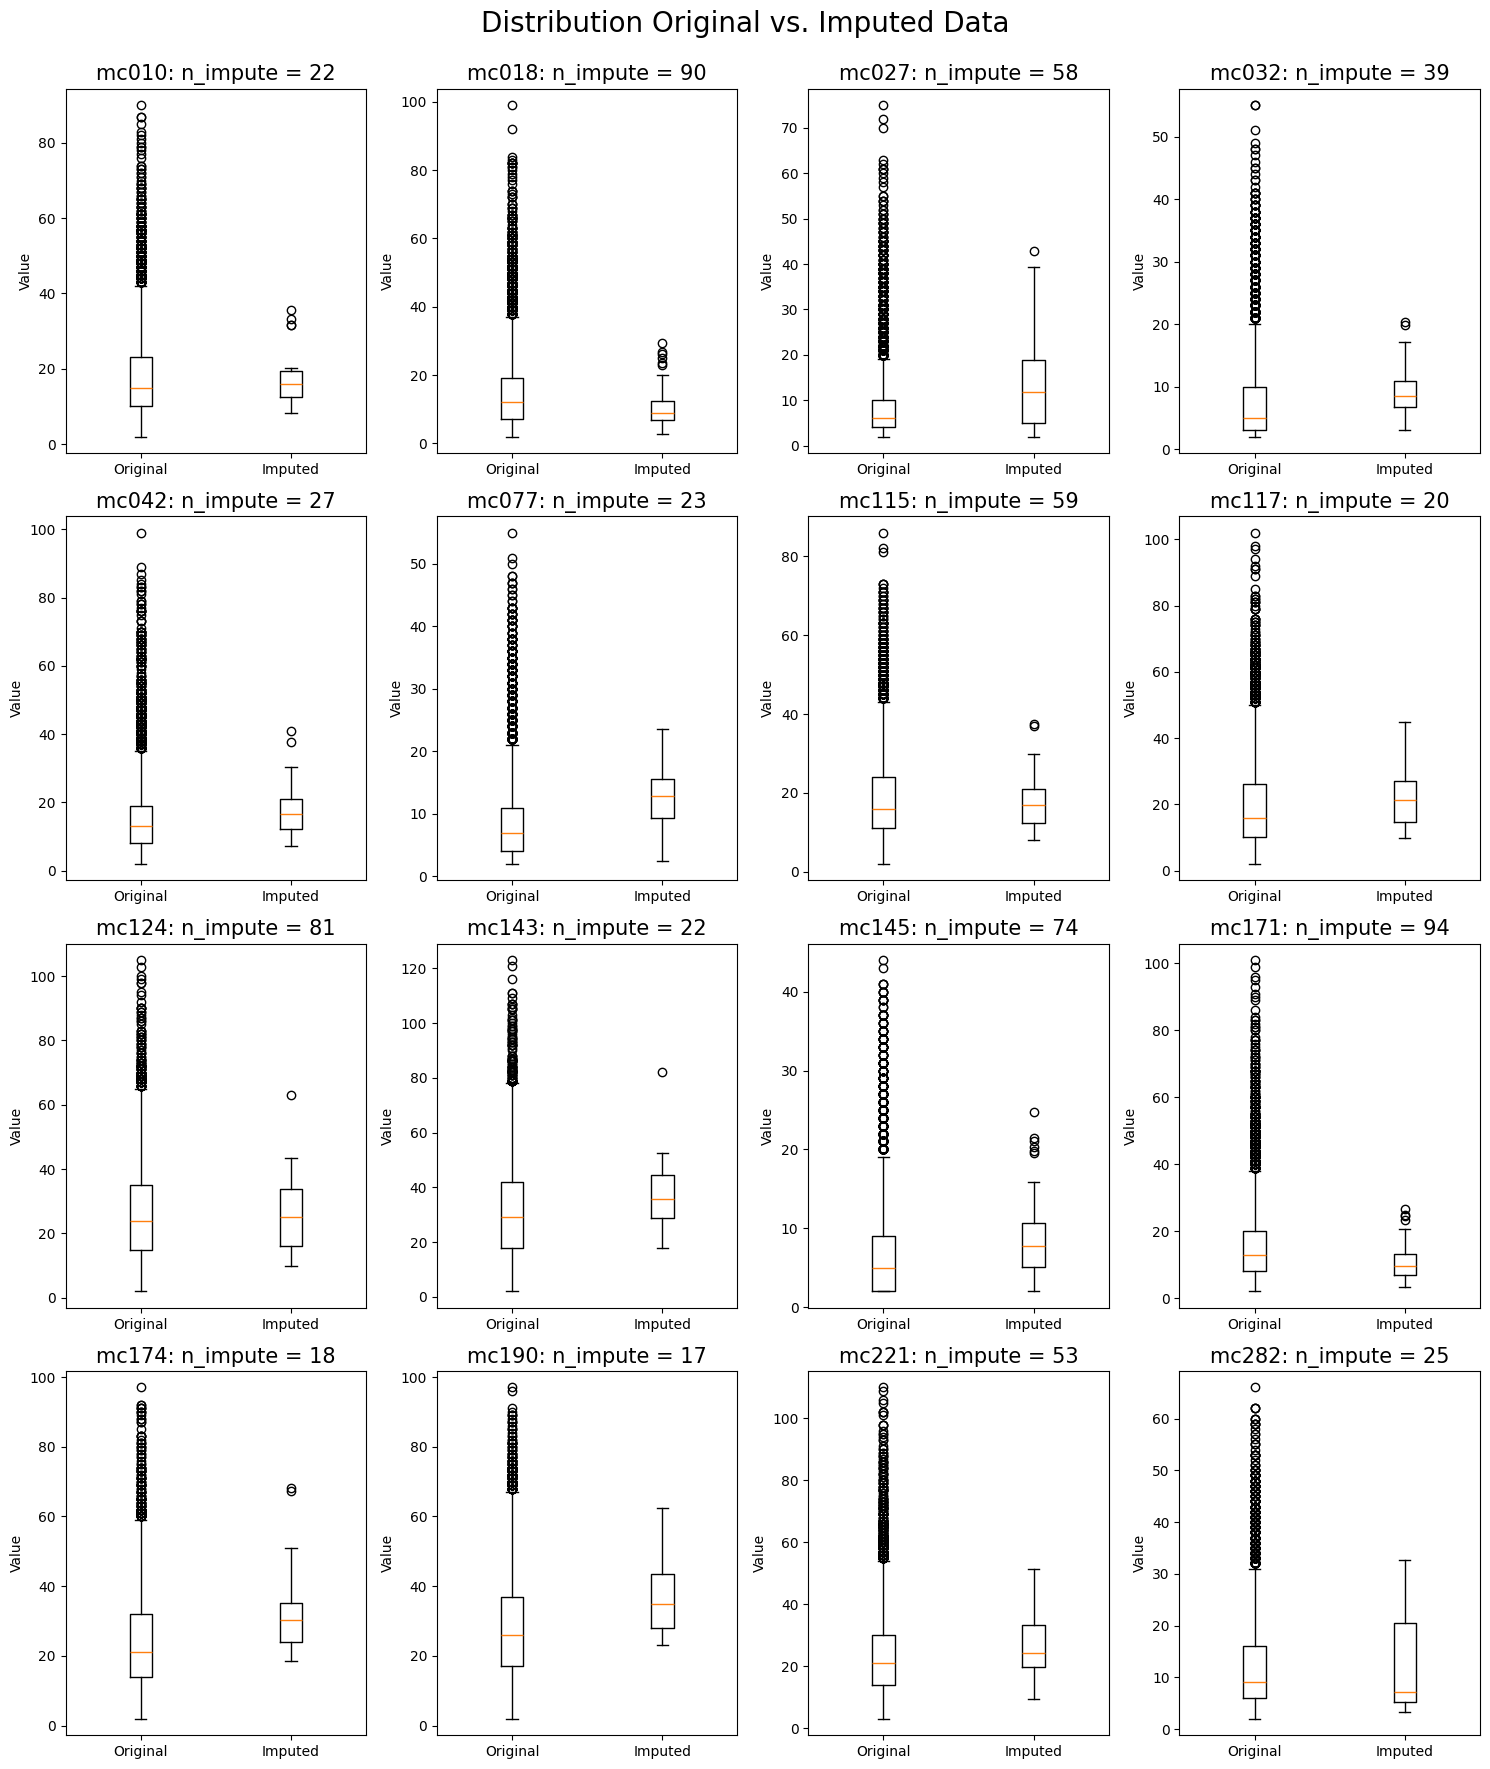

In [27]:
# boxplot with distribution existing value vs true values
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(15, 18))  
fig.suptitle(f'Distribution Original vs. Imputed Data\n', size = 20)
axes = axes.flatten()

for i, site in enumerate(df_impute.columns.drop('MESS_DATUM')):
    data_to_plot = [pivot_df[site].dropna(), imputed_data[site]]
    axes[i].boxplot(data_to_plot, tick_labels=['Original', 'Imputed'])
    axes[i].set_title(f'{site}: n_impute = {len(imputed_data[site])}', size = 15)
    axes[i].set_ylabel('Value')
    
plt.tight_layout()
plt.savefig('output/NO2_pollution/Distribution_imputation_target_variable_boxplot.png', dpi = 180)
plt.show()


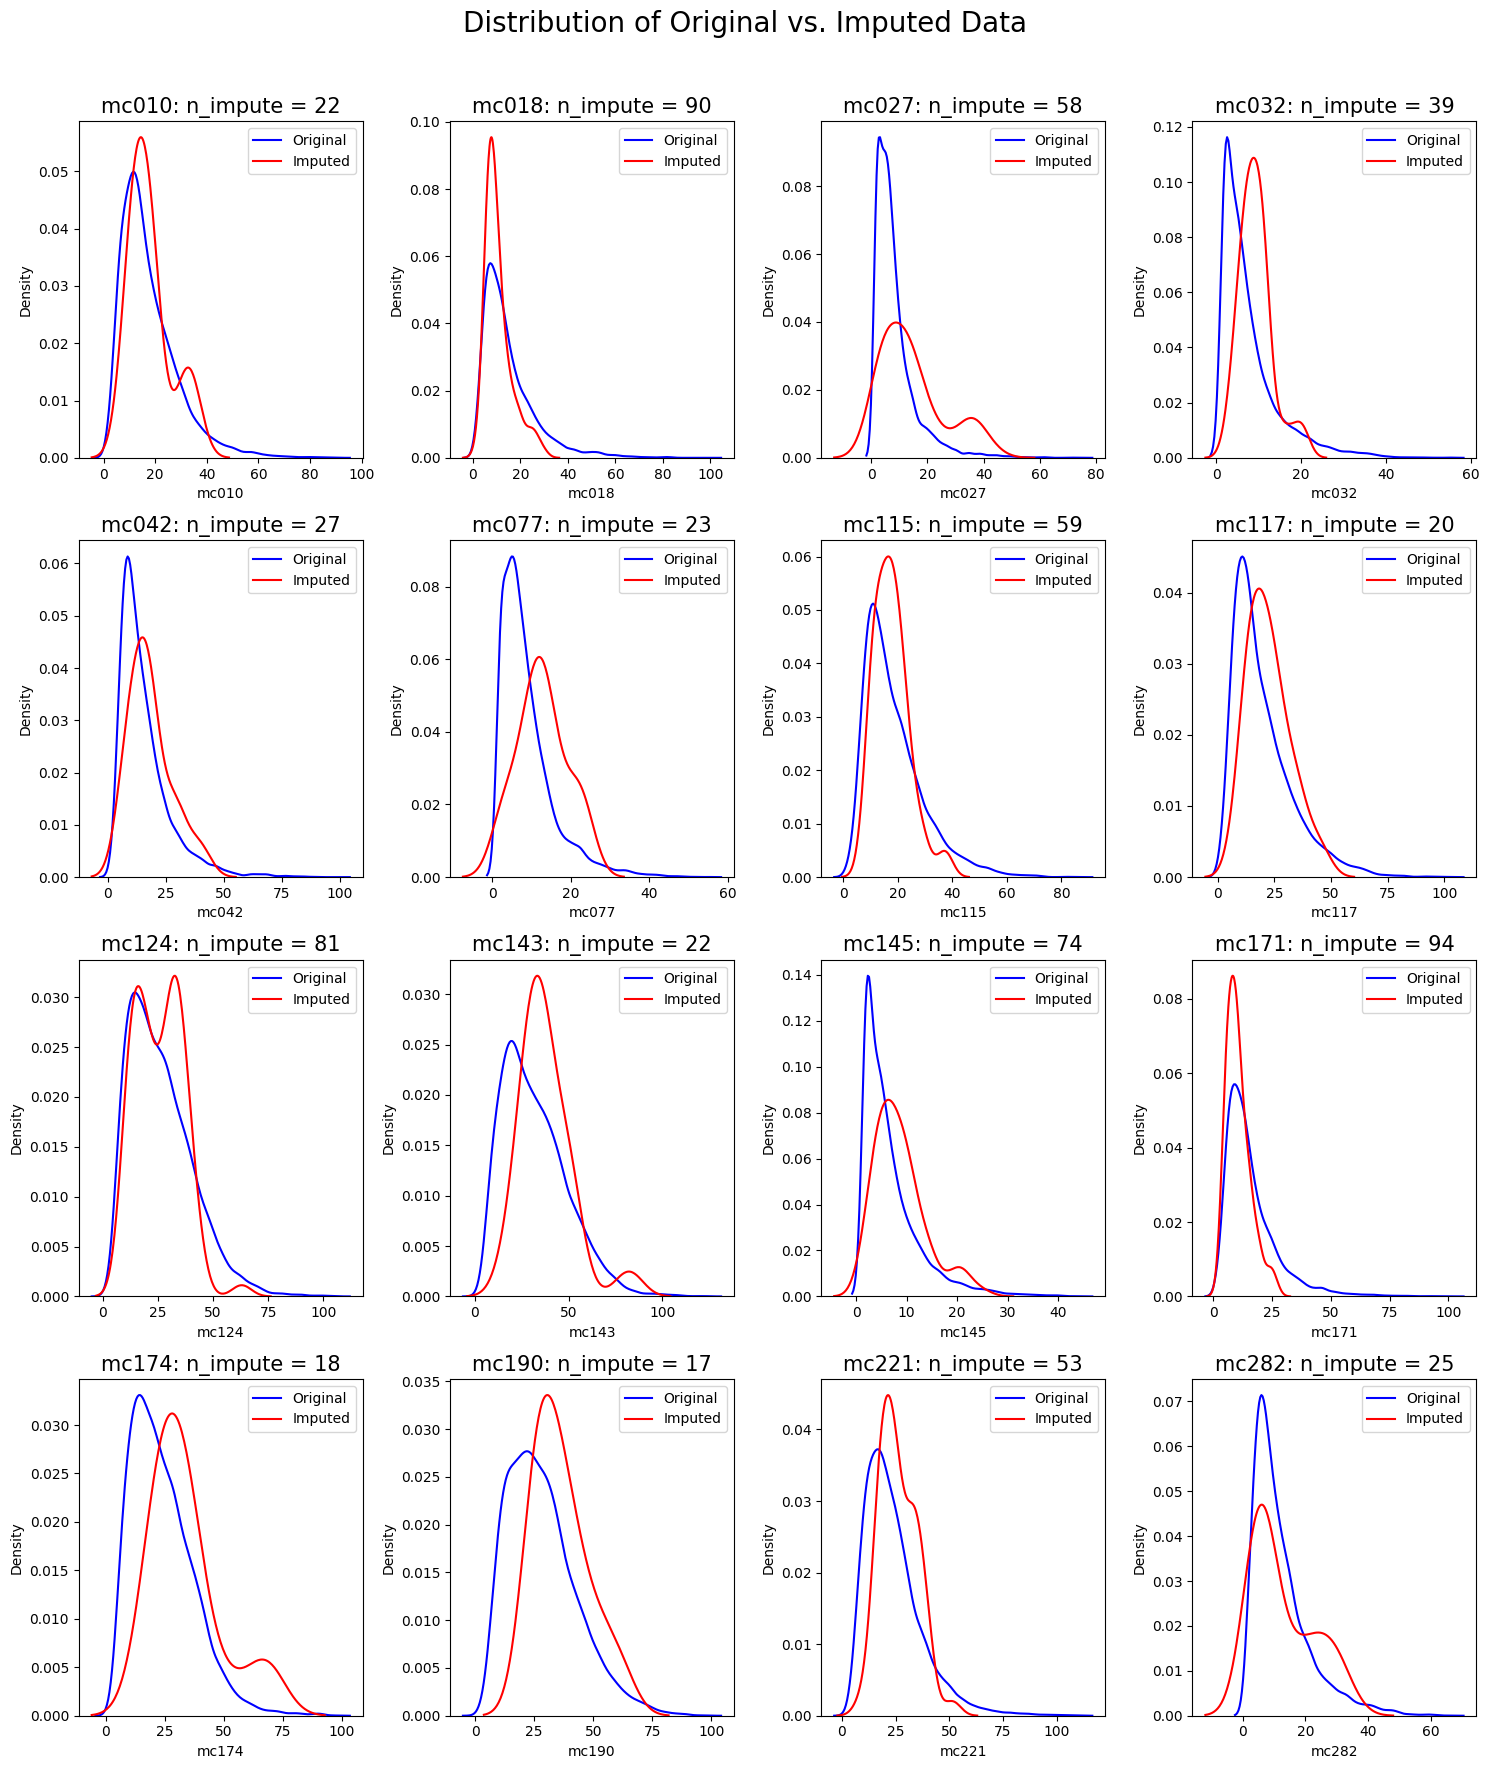

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(4, 4, figsize=(15, 18))  # Adjust the size as needed
fig.suptitle('Distribution of Original vs. Imputed Data\n\n', size=20)
axes = axes.flatten()

# Iterate over each site and plot subplot
for i, site in enumerate(df_impute.columns.drop('MESS_DATUM')):
    # Original data
    sns.kdeplot(pivot_df[site].dropna(), ax=axes[i], color='blue', label='Original')
    # Imputed data
    sns.kdeplot(imputed_data[site], ax=axes[i], color='red', label='Imputed')
    
    axes[i].set_title(f'{site}: n_impute = {len(imputed_data[site])}', size=15)
    axes[i].set_ylabel('Density')
    axes[i].legend()  


plt.tight_layout()
plt.savefig('output/NO2_pollution/Distribution_imputation_target_variable_graph.png', dpi = 180)
plt.show()
